In [104]:
# IMPORT relevant modules
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import cv2
import glob
import time
import os
import logging
import argparse
import sys
import math
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML
#imageio.plugins.ffmpeg.download()


PREV_LEFT_SLOPE = 0
PREV_RIGHT_SLOPE = 0
PREV_LEFT_POINTS = [0,0,0]
PREV_RIGHT_POINTS = [0,0,0]

def reset_vars():
    global PREV_LEFT_SLOPE 
    global PREV_RIGHT_SLOPE 
    global PREV_LEFT_POINTS 
    global PREV_RIGHT_POINTS 
    
    PREV_LEFT_SLOPE = 0
    PREV_RIGHT_SLOPE = 0
    PREV_LEFT_POINTS = [0,0,0]
    PREV_RIGHT_POINTS = [0,0,0]
    


In [105]:
def camera_cal(folder,file,pattern_x,pattern_y,square_size):
    
    # pattern_x = 10 
    # pattern_y = 7
    # square_size = 1

    pattern_size = (pattern_x -1, pattern_y - 1) 
    pattern_points = np.zeros((np.prod(pattern_size), 3), np.float32)
    pattern_points[:, :2] = np.indices(pattern_size).T.reshape(-1, 2)
    pattern_points *= square_size

    obj_points = []
    img_points = []
    h, w = 0, 0
    img_names_undistort = []
    
    # create image list
    images = glob.glob('./'+folder+'/'+file+'*'+'.jpg')
    out_path = glob.glob('./'+folder+'/')
    out = False
    
    for fn in images:
        #print('processing %s... ' % fn, end='')
        img = cv2.imread(fn)
        if img is None:
            #print("Failed to load", fn)
            continue
        h, w = img.shape[:2]
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, pattern_size)
        if ret:
            term = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
            cv2.cornerSubPix(gray, corners, (5, 5), (-1, -1), term)
            img_points.append(corners)
            #.reshape(-1, 2)
            obj_points.append(pattern_points)

        if out:
            cv2.drawChessboardCorners(vis, pattern_size, corners, found)
            outfile = glog.glob(out_path+file+'_chess.png')
            cv2.imwrite(outfile, vis)
            if found:
                img_names_undistort.append(outfile)
        if not ret:
            #print('chessboard not found')
            continue

    #print('ok')

    # calculate camera distortion
    rms, camera_matrix, dist_coefs, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, (w, h), None, None)

    #print("\nRMS:", rms)
    #print("camera matrix:\n", camera_matrix)
    # print("matrix: \n", type(camera_matrix))
    #print("distortion coefficients: ", dist_coefs.ravel())
    
    return(camera_matrix,dist_coefs)
    
def undistort_1(image, camera_matrix, dist_coefs):
    image = cv2.undistort(image,camera_matrix,dist_coefs)
    return(image)

def undistort_2(image,camera_matrix, dist_coefs):
    h,w =image.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w, h), 1, (w, h))
    undst = cv2.undistort(image, camera_matrix, dist_coefs, None, newcameramtx)
    x, y, w, h = roi
    undst = undst[y:y+h, x:x+w]
    return(undst)

In [106]:
# CALL CAMERA CALIBRATION FUNCTION
camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)

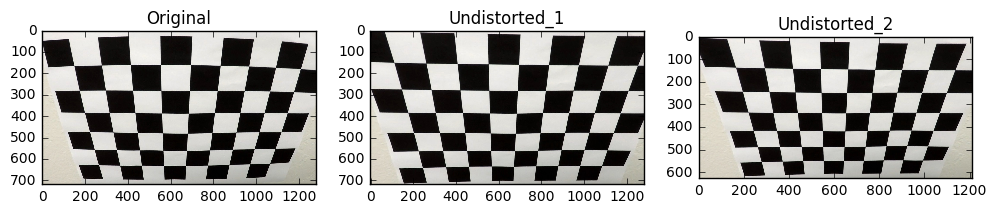

In [107]:
# TEST DISTORTION CORRECTION

distorted_image = mpimg.imread("./camera_cal/calibration2.jpg")
corrected1 = undistort_1(distorted_image, camera_matrix, dist_coefs)
corrected2 = undistort_2(distorted_image, camera_matrix, dist_coefs)


f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(12, 18))
ax1.imshow(distorted_image)
ax1.set_title('Original', fontsize=12)
ax2.imshow(corrected1)
ax2.set_title('Undistorted_1', fontsize=12)
ax3.imshow(corrected2)
ax3.set_title('Undistorted_2', fontsize=12)

In [108]:
def warper(image, src, dst):

    # Compute and apply perpective transform
    img_size = (image.shape[1], image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped


In [109]:
def illuminationHSV(image):
    rows,cols,channels = image.shape
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(image_hsv)
    #cv2.normalize(h, h, alpha=0, beta=127, norm_type=cv2.NORM_MINMAX)
    #cv2.normalize(s, s, alpha=0, beta=127, norm_type=cv2.NORM_MINMAX)
    #newImage = cv2.add(h,s)
    #cv2.normalize(newImage, newImage, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    if np.average(v) < 100:
        return s
    else:
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def pre_process_canny(image):
    """
    Takes in an image and uses Canny Edge Detection 
    """
    # PARAMETERS
    imshape = image.shape
    kernel_size = 5
    sigma_x = 5
    sigma_y = 30
    low_canny_threshold = 25
    high_canny_threshold = low_canny_threshold * 3
    
    
    # GRAYSCALE
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #gray = illuminationHSV(image)
    
    #equalize HIST
    #gray2 = cv2.equalizeHist(gray)
    
    # GAUSSIAN BLUR
    smooth = cv2.GaussianBlur(gray, (kernel_size, kernel_size), sigma_x, sigma_y)
    
    # CANNY EDGES
    canny_edges = cv2.Canny(smooth, low_canny_threshold, high_canny_threshold)
    kernel = np.ones((5,5), np.uint8)
    edges = cv2.dilate(canny_edges, kernel, iterations=1)
    
    if len(np.nonzero(canny_edges)[0]) > 30000:
        edges = cv2.Canny(smooth, 75, 180, apertureSize=3)
    '''    
    f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(12, 18))
    ax1.imshow(gray, cmap = 'Greys_r')
    ax1.set_title('grayscale', fontsize = 12)
    ax2.imshow(smooth, cmap = 'Greys_r')
    ax2.set_title('Gausian Blur', fontsize=12)
    '''
    
    return edges


In [110]:
def colorfilter(frame):
    
    image = np.copy(frame)
    # Convert BGR to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of blue color in HSV
    
    
    lower_yellow = np.array([90,50,50])
    upper_yellow = np.array([100,255,255])
   
    #Threshold the HSV image to get only yellow colors
    mask1 = cv2.inRange(hsv, lower_yellow, upper_yellow)
    # Bitwise-AND mask and original image
    res1 = cv2.bitwise_and(frame,frame, mask= mask1)
    
    lower_white = np.array([200,200,200])
    upper_white = np.array([255,255,255])
    
    #Threshold the RBG image to get only white colors
    mask2 = cv2.inRange(image, lower_white, upper_white)
    # Bitwise-AND mask and original image
    res2 = cv2.bitwise_and(image,image, mask= mask2)
    
    res = res1 + res2
    
    return(res[:,:,0])
'''
res = colorfilter(top_view)
plt.imshow(res,cmap = 'Greys_r')
'''


"\nres = colorfilter(top_view)\nplt.imshow(res,cmap = 'Greys_r')\n"

In [111]:
#can_frm = pre_process_canny(undst)
#plt.imshow(can_frm,cmap='Greys_r')

In [112]:
def roi_mask(image):

    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    imshape = image.shape
    ''' 
    y_max = imshape[0]-70
    y_min = 11*imshape[0]/18
    x_min = 0
    x_1 = 9*imshape[1]/20
    x_2 = 11*imshape[1]/20
    x_max = imshape[1]
    '''
    y_max = imshape[0]-70
    y_min = imshape[0]/10
    x_min = 0 + 80
    x_1 = 5*imshape[1]/20
    x_2 = 15*imshape[1]/20
    x_max = imshape[1] - 80
    
    
    vertices = np.array([[(x_min,y_max), (x_1, y_min), (x_2, y_min),(x_max,y_max)]], dtype=np.int32)
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(imshape) > 2:
        channel_count = imshape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, [vertices], ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [113]:
# line detection

def line_detect(roi_frm, prob_hough= True):
    
    h,w = roi_frm.shape   # height and width in pixels

    rho = 1             # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180 # angular resolution in radians of the Hough grid
    hough_threshold = 100      # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    line_image = np.copy(orig_img)*0 # creating a blank to draw lines on

    #print(line_image.shape)


    # Run Probabilistic Hough Transform to extract line segments from Binary image.
    lines = cv2.HoughLinesP(roi_frm,rho,theta,hough_threshold,min_line_length,max_line_gap)

    #print('%d lines detect ...' % lines.shape[0],end='')

    y_max = h-20
    y_min = 0
    
    global PREV_LEFT_SLOPE, PREV_RIGHT_SLOPE, PREV_LEFT_POINTS, PREV_RIGHT_POINTS

    # DECLARE VARIABLES
    prev_weight = 0.9

    r_XY_arr = []
    r_Y_arr = []
    r_X_arr = []
    r_Slope_arr = []

    l_XY_arr = []
    l_Y_arr = []
    l_X_arr = []
    l_Slope_arr = []


    #print(' processing ...',end='')
    # Loop for every single line detected by Hough Transform

    for line in lines:
        for x1,y1,x2,y2 in line:
            dx = x2 - x1
            dy = y2 - y1
            slope, yint = np.polyfit((x1, x2), (y1, y2), 1)
            theta = np.abs(np.arctan2((y2-y1), (x2-x1)))
            angle = theta * (180/np.pi)
            #angle = np.arctan2(np.array(y2-y1,dtype=np.float32),np.array(x2-x1,dtype=np.float32)) * (180/np.pi)
            if abs(angle)>20:         #for removing horizontal lines
                #print (x1,y1,x2,y2,angle)
                #cv2.line(line_image,(x1,y1),(x2,y2),(0,255,0),2)
                # Right lane marking -> positive slope and in right half of the frame
                if x1 > 0.4*w and x2 > 0.4*w:
                    #print('right',x1,y1,x2,y2,angle)
                    r_Y_arr.extend([y1,y2])
                    r_X_arr.extend([x1,x2])
                    #r_XY_arr = np.append(r_XY_arr,[[x1,x2],[y1,y2]],1)
                    r_Slope_arr.append(slope)
                    #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
                # left lane marking -> negative slope and in left half of the frame
                elif x1 < 0.6*w and x2 < 0.6*w:
                    #print('left',x1,y1,x2,y2,angle)
                    l_Y_arr.extend([y1,y2])
                    l_X_arr.extend([x1,x2])
                    #l_XY_arr = np.append(l_XY_arr,[[x1,x2],[y1,y2]],1)
                    l_Slope_arr.append(slope)
                    #cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
    
    r_XY_arr = np.array((r_X_arr, r_Y_arr))
    l_XY_arr = np.array((l_X_arr, l_Y_arr))
    data_lanes = np.array((l_Slope_arr,r_Slope_arr,l_XY_arr,r_XY_arr))
                
    # DRAW RIGHT LANE LINE
    if r_Y_arr:
        r_ind = r_Y_arr.index(min(r_Y_arr))
        r_x1 = r_X_arr[r_ind]
        r_y1 = r_Y_arr[r_ind]
        r_slope = np.median(r_Slope_arr)
        #print('R_slope=',r_slope)
        
        r_x_min = np.min(r_X_arr)
        r_x_max = np.max(r_X_arr)
        r_y_min = np.min(r_Y_arr)
        r_y_max = np.max(r_Y_arr)
        
        cv2.rectangle(line_image, (r_y_min,r_x_min-10), (r_y_max,r_x_max+10), [255,255,255], 10)
        
        #UPDATE SLOPE
        if PREV_RIGHT_SLOPE !=0:
            r_slope = r_slope + (PREV_RIGHT_SLOPE - r_slope) * prev_weight
            
        if r_slope < 0.15: 
            r_x2 = r_x1;
        else:
            r_x2 = int(r_x1 + (y_max - r_y1) / r_slope)
            
        print('r_x2=',r_x2)

        # UPDATE REST OF THE COORDINATES
        if PREV_RIGHT_SLOPE !=0:
            r_x1 = int(r_x1 + (PREV_RIGHT_POINTS[0] - r_x1) * prev_weight)
            r_y1 = int(r_y1 + (PREV_RIGHT_POINTS[1] - r_y1) * prev_weight)
            r_x2 = int(r_x2 + (PREV_RIGHT_POINTS[2] - r_x2) * prev_weight)

        PREV_RIGHT_SLOPE = r_slope
        PREV_RIGHT_POINTS = [r_x1, r_y1, r_x2]
        print('Right',r_x1, r_y1, r_x2, y_max,r_slope)
        cv2.line(line_image, (r_x1, r_y1), (r_x2, y_max), (255,0,0), 15)
    else:
        print('No Right Lane!!!')
        

    # DRAW LEFT LANE LINE
    if l_Y_arr:
        l_ind = l_Y_arr.index(min(l_Y_arr))
        #l_ind = l_X_arr.index(max(l_X_arr))
        l_x1 = l_X_arr[l_ind]
        l_y1 = l_Y_arr[l_ind]
        #l_slope = np.median(l_Slope_arr)
        l_slope = np.average(l_Slope_arr)
        #print('l_slope=',l_slope)
        if PREV_LEFT_SLOPE !=0:
            l_slope = l_slope + (PREV_LEFT_SLOPE - l_slope) * prev_weight
            
        if l_slope < 0.15:
            l_x2 = l_x1
        else:
            l_x2 = int(l_x1 + (y_max - l_y1) / l_slope)
            
        print('l_x2=',l_x2)

        if PREV_LEFT_SLOPE !=0:
            l_x1 = int(l_x1 + (PREV_LEFT_POINTS[0] - l_x1) * prev_weight)
            l_y1 = int(l_y1 + (PREV_LEFT_POINTS[1] - l_y1) * prev_weight)
            l_x2 = int(l_x2 + (PREV_LEFT_POINTS[2] - l_x2) * prev_weight)

        PREV_LEFT_SLOPE = l_slope
        PREV_LEFT_POINTS = [l_x1, l_y1, l_x2]
        print('Left' ,l_x1, l_y1, l_x2, y_max,l_slope)
        cv2.line(line_image, (l_x1, l_y1), (l_x2, y_max), (255,0,0), 15)
    else:
        print('No Left Lane !!!')
    
    return(line_image,data_lanes)

In [114]:
'''
# Create a "color" binary image to combine with line image
#color_edges = np.dstack((line_image, line_image, line_image)) 
line_image, data_lanes = line_detect(roi_frm, prob_hough= True)

# Draw the lines on the edge image
combo = cv2.addWeighted(line_image, 0.8, undst, 1, 0) 
plt.imshow(combo)
'''


'\n# Create a "color" binary image to combine with line image\n#color_edges = np.dstack((line_image, line_image, line_image)) \nline_image, data_lanes = line_detect(roi_frm, prob_hough= True)\n\n# Draw the lines on the edge image\ncombo = cv2.addWeighted(line_image, 0.8, undst, 1, 0) \nplt.imshow(combo)\n'

In [115]:
## SELECTING POINTS BASED ON SLOPES
def process_slopes(data_lanes):
    print(len(data_lanes[0]))
    l_slope_sdev = np.std(data_lanes[0])
    l_slope_median = np.median(data_lanes[0])
    l_slope_avg = np.average(data_lanes[0])
    l_slope_min = np.min(data_lanes[0])
    l_slope_max = np.max(data_lanes[0])
    l_angle_min = np.arctan(np.abs(l_slope_min)) * 180/(np.pi)
    l_angle_max = np.arctan(np.abs(l_slope_max)) * 180/(np.pi)
    print(l_slope_median,l_slope_avg,l_slope_sdev,l_slope_min,l_slope_max,l_angle_min,l_angle_max)

    l_slope_upper = l_slope_avg + l_slope_sdev
    l_slope_lower = l_slope_avg - l_slope_sdev
    l_angle_lower = np.arctan(np.abs(l_slope_lower)) * 180/(np.pi)
    l_angle_upper = np.arctan(np.abs(l_slope_upper)) * 180/(np.pi)
    print(l_slope_lower,l_slope_upper,l_angle_lower,l_angle_upper)

    cnt = 0;
    l_ind = []
    for sl in data_lanes[0]:
        if sl > l_slope_lower and sl<=l_slope_upper:
            l_ind = np.append(l_ind,cnt)
        cnt = cnt + 1
    print(len(l_ind))
    print(int(l_ind))
    #l_XYs = data_lanes[:,int(l_ind)]

    print(len(data_lanes[1]))
    r_slope_sdev = np.std(data_lanes[1])
    r_slope_median = np.median(data_lanes[1])
    r_slope_avg = np.average(data_lanes[1])
    r_slope_min = np.min(data_lanes[1])
    r_slope_max = np.max(data_lanes[1])
    r_angle_min = np.arctan(np.abs(r_slope_min)) * 180/(np.pi)
    r_angle_max = np.arctan(np.abs(r_slope_max)) * 180/(np.pi)
    print(r_slope_median,r_slope_avg,r_slope_sdev,r_slope_min,r_slope_max,r_angle_min,r_angle_max)
    
    return(l_slope_lower,l_slope_upper)

In [116]:
def ransac(image, edges, points):
    ''' Performs the RANSAC algorithm upon an input
        image and its corresponding pre-processed
        image, outputting an image with lines drawn
        on it and printing the amount of lines to stdout '''
    
    # Initialise variables
    rows,cols,channels = image.shape
    white = np.nonzero(edges)
    length = len(white[0])
    
    densestLine = -1
    bestInliers = 0
    lineCounter = 0
    iterations = 10000
    
    # While we have strong lines (probably road edges), enough edges and not
    # more than 4 lines (roads in UK don't have more 4)
    while bestInliers > (densestLine / 2) and lineCounter < 5 and length > 1000:
        # Build a bank of the locations of edge pixels
        white = np.nonzero(edges)
        length = len(white[0])
        
        # Initialise variables
        bestInliers = 0
        bestLine = []
        
        # Find lines, updating best if beaten
        for i in range (iterations + 1):
            # Select two random points
            rand1 = random.randrange(length)
            rand2 = random.randrange(length)
            x1,y1 = white[1][rand1],white[0][rand1]
            x2,y2 = white[1][rand2],white[0][rand2]
            # Heuristic to eliminate vertical and horizontal lines
            # keep selecting points until heuristics aren't violated
            cycles = 0
            while abs(x1 - x2) < 50 or abs(y1 - y2) < 50 or abs(x1 - x2) > 200:
                rand1 = random.randrange(length)
                rand2 = random.randrange(length)
                x1,y1 = white[1][rand1],white[0][rand1]
                x2,y2 = white[1][rand2],white[0][rand2]
                cycles += 1
                if cycles > 100000:
                    break
            # Create blank image
            lineImage = np.zeros((rows,cols), np.uint8)
            # Draw line between two points on blank image
            cv2.line(lineImage, (x1,y1), (x2,y2), (255,255,255), 1)
            # Logically AND the line image and processed image
            intersect = cv2.bitwise_and(edges, lineImage)
            # Calculate the number of inliers to the line
            inliers = cv2.countNonZero(intersect)
            # Modify best if necessary
            if inliers >= bestInliers:
                bestInliers = inliers
                bestLine = [(x1,y1), (x2,y2)]
            if cycles > 100000:
                break
        # Update global best to help know when to stop
        if bestInliers > densestLine:
            densestLine = bestInliers
        # Only draw line if it's a strong line (potential road edge)
        if bestInliers > (densestLine / 2):
            # Draw the line on the image
            cv2.line(image, bestLine[0], bestLine[1], (0,0,255), 1)
            # Prevent choosing this same line again my removing edges
            cv2.line(edges, bestLine[0], bestLine[1], (0,0,0), 75)
            lineCounter += 1
        if cycles > 100000:
            break
    return [image, lineCounter]

In [137]:
# PIPELINE
def pipeline(image,camera_matrix, dist_coefs, src, dst):
    print('Pipeline initiated ...')
    reset_vars()
    
    frame = np.copy(image)
    #orig_img = mpimg.imread(path)
    img_size = frame.shape

    corrected_img = undistort_1(frame, camera_matrix, dist_coefs)
    print('Distortion corrected')

    top_view = warper(corrected_img,src,dst)
    canny_edges = pre_process_canny(top_view)
    #lane_pixels = colorfilter(top_view)
    #roi_frm = roi_mask(canny_edges)
    
    print('Edges Detected')
    
    #print(canny_edges.dtype)
    #print(lane_pixels.dtype)
    hough_input = canny_edges #+lane_pixels

    line_image, data_lanes = line_detect(hough_input,True)
    
    print('Hough lines found')

    # Draw the lines on the edge image
    combo = cv2.addWeighted(line_image, 0.9, top_view, 1, 0) 

    dist_view = warper(line_image,dst,src)
    # Draw the lines on the edge image
    combo_2 = cv2.addWeighted(dist_view, 0.9, corrected_img, 1, 0) 
    
    print('... Pipeline complete!')

    # plt.imshow(roi_frm,cmap='Greys_r')
    
    f, ((ax1, ax2, ax3, ax4, ax5)) = plt.subplots(5, 1, figsize=(12, 18))
    ax1.imshow(orig_img)
    ax1.set_title('original image', fontsize = 12)
    ax2.imshow(top_view)
    ax2.set_title('IPM', fontsize=12)
    ax3.imshow(hough_input, cmap = 'Greys_r')
    ax3.set_title('Edges', fontsize=12)
    ax4.imshow(combo)
    ax4.set_title('Hough line', fontsize=12)
    ax5.imshow(combo_2)
    ax5.set_title('Hough line unwarped', fontsize=12)
    
    
    return(combo_2)

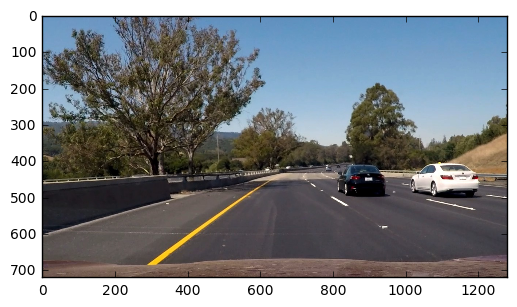

In [138]:
# PARAMETERS

#path = glob.glob('./'+'test_images'+'/'+'test6.jpg')
path = '/Users/enterprise/Dev/Git/Lane-Detection/test_images/test6.jpg'

cal_images_path = 'camera_cal'
test_images_path = glob.glob('test_images/*.jpg')
output_image_path = 'output_images/Run_'
output_video_path = 'output_videos/Run_'


orig_img = mpimg.imread(path)
plt.imshow(orig_img)
#printing out some stats and plotting
#img_size = orig_img.shape
#print('This image is:', type(orig_img), 'with dimesions:', img_size)



src =  np.float32([[260,680],[1045,680],[540,490],[750,490]])
dst = np.float32([[300,700],[1100,700],[300,50],[1100,50]])


    

Pipeline initiated ...
Distortion corrected
Edges Detected
r_x2= 1221
Right 1221 144 1221 700 -14.641025641
l_x2= 398
Left 398 0 398 700 -12.2767230942
Hough lines found
... Pipeline complete!


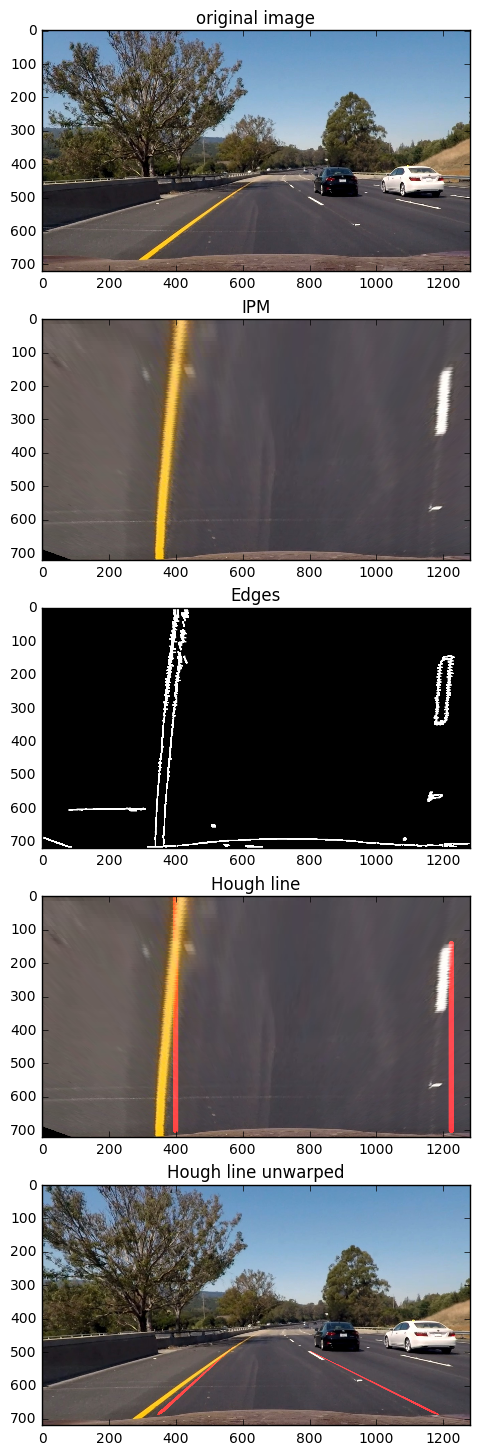

In [139]:
output = pipeline(orig_img,camera_matrix, dist_coefs, src, dst)
plt.imshow(output)

In [124]:
# Test Images

camera_matrix, dist_coefs = camera_cal('camera_cal','calibration',10,7,1)

#fig, axs = plt.subplots(6,2, figsize=(12, 18), facecolor='w', edgecolor='k')
#axs = axs.ravel()

# create image list    
for ind, fn in enumerate(test_images_path):
    print('processing %s... ' % fn, end='')
    img = mpimg.imread(fn)
    if img is None:
        print("Failed to load", fn)
        continue
    result = pipeline(img,camera_matrix, dist_coefs, src, dst)
    print('ok',ind)
    #plt.imshow(result)
    #'''
    fig, ((axs1, axs2)) = plt.subplots(1,2, figsize=(12, 18), facecolor='w', edgecolor='k')
    axs1.imshow(img)
    axs1.set_title('Test', fontsize = 12)
    axs2.imshow(output)
    axs2.set_title('Output', fontsize = 12)
    plt.show()
    #'''
    result = None
    


processing test_images/exit-ramp.jpg... pipeline initiated ...
distortion corrected
Edge Detection
No Right Lane!!!
No Left Lane !!!
Hough Transform


error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [ ]:
# Test Videos